In [1]:
# Import dependencies
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from nltk.tokenize import TweetTokenizer
import time
from torch_scatter import scatter_max, scatter_mean, scatter_std
from sklearn.model_selection import KFold
import torchmetrics
import lightning as L
from torch_geometric.data import Batch, Data
from tqdm import tqdm
import spacy
import string
import os
import re
import math
from torch import nn
from torch.utils.flop_counter import FlopCounterMode
from torch_geometric.nn import GATv2Conv
from tqdm import tqdm
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, hinge_loss
from torchmetrics import ConfusionMatrix
from codes.scripts.utilities import ClassifierModelManager, CnnGnnClassifierLightningModel

In [2]:
# Load tokenizers
nlp = spacy.load('en_core_web_lg', disable=['tok2vec','tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner'])
t_tokenizer = TweetTokenizer()
nlp.max_length = len(' '.join(list(nlp.vocab.strings)))+1
all_vocab_doc = nlp(' '.join(list(nlp.vocab.strings)))
all_vocab_str = [f'{t}' for t in all_vocab_doc]

In [3]:
# Setup base hyper parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 50
folder_path = r'data\TextClassification\review_polarity'
t_tokenizer = TweetTokenizer()
device

device(type='cuda')

In [4]:
# Load rt-2k movie reviews dataset
def load_dataset(dataset_path, shuffle = False):
    pos_path = os.path.join(dataset_path, 'pos')
    neg_path = os.path.join(dataset_path, 'neg')
    pos_names = os.listdir(pos_path)
    neg_names = os.listdir(neg_path)
    df = []
    for pname in pos_names:
        file_path = os.path.join(pos_path, pname)
        with open(file_path, 'rt', encoding='utf8') as f:
            df.append([1, f.read()])
    
    for nname in neg_names:
        file_path = os.path.join(neg_path, nname)
        with open(file_path, 'rt', encoding='utf8') as f:
            df.append([0, f.read()])
    df = pd.DataFrame(data=df, columns=['label', 'text'])
    if shuffle:
        df = df.sample(frac=1).reset_index(drop=True)
    return df
keep_ratio = 1.0
df = load_dataset(r'Data\TextClassification\review_polarity')
# df.text = df.text.apply(lambda d: d[:50])
df.dropna(inplace=True)
df = df.iloc[:int(keep_ratio*df.shape[0])]
target_classes = ["Negative", "Positive"]
df.shape

(2000, 2)

In [5]:
# Setup class label-id dictionaries
class_list = df.label.unique()
class_id = {target_classes[i]:i for i in class_list}
id_class = {i:target_classes[i] for i in class_list}

In [6]:
# Collect document characters and create character-id dictionaries
char_set = set()
for doc in df.text.values:
    char_set.update(set(' '.join(t_tokenizer.tokenize(doc))))
allowed_chars = string.ascii_letters + string.digits + string.punctuation + ' '
all_chars = set(''.join(char_set).join(allowed_chars))
vocab_dict = {c:i for i, c in enumerate(all_chars)}
if '\x01' not in vocab_dict:
    vocab_dict['\x01'] = len(vocab_dict)
char_Set = set(vocab_dict.keys())
num_embedding = len(vocab_dict)
vocab_dict_rev = dict(zip(list(vocab_dict.values()), list(vocab_dict.keys())))

In [7]:
# Dataset prepared for K-Fold cross validation
class KFoldCharacterandTokenLevelDataset(Dataset):
    
    def __init__(self, X, y, num_classes, char_dict, tokenizer, shuffle=True, batch_size=128, k_folds=10, fold_idx=0) -> None:
        super().__init__()
        self.fold_idx = fold_idx
        kf = KFold(k_folds, shuffle=True, random_state=42)
        self.k_folds = list(kf.split(np.arange(len(y))))
        self.k_folds = [(np.array(f[0], dtype=np.longlong), np.array(f[1], dtype=np.longlong)) for f in self.k_folds]
        
        if batch_size > len(y)//k_folds:
            batch_size = len(y)//k_folds
        self.batch_size = batch_size
        
        if len(y) % batch_size*k_folds != 0:
            
            self.shortage = ((len(y) // (batch_size*k_folds))+1)*(batch_size*k_folds) - len(y)
            print(f"!!!! This amount of data added: {self.shortage}, change batch size or k-fold to reduce it!")
            empty_labels = [i%2 for i in range(self.shortage)]
            empty_strings = [id_class[l] for l in empty_labels]
            y = np.concatenate([y, empty_labels])
            X = np.concatenate([X, empty_strings])
        
        y = torch.from_numpy(y)
        self.shuffle = shuffle
        self.y = torch.nn.functional.one_hot(y, num_classes=num_classes).float()
        self.X = X
        self.char_dict = char_dict
        self.char_Set = set(char_dict.keys())
        self.vocab_size = len(self.char_dict)
        self.tokenizer = tokenizer
        # self.token_dict = token_dict
        # self.sentiment_dict = sentiment_dict
        self.max_token_count = 0
        
        self.all_data = []
        self.token_lengths = []
        self.token_embeddign_ids = []
        
        self.sum_a = 0
        
        for doc in tqdm(self.X):
            # tokens = self.tokenizer(''.join(c for c in doc if c in self.char_Set))
            # tokens = [t.text for t in tokens]
            tokens = self.tokenizer(doc)
            if len(tokens) == 0:
                tokens = ['empty']
                            
            token_lengths = [len(t) for t in tokens]
            tokens.append('\x01')
            
            token_lengths.append(len(tokens[-1])-1)
            token_lengths = torch.from_numpy(np.array(token_lengths, dtype=np.longlong))+1
            # token_embs = [self.token_dict[t] if t in self.token_dict else torch.zeros((64, ), dtype=torch.float32) for t in tokens]
            # token_sentiments = [self.sentiment_dict[t] if t in self.sentiment_dict else (0.0, 0.0) for t in tokens]
            # token_embs = torch.from_numpy(np.array(token_embs, dtype=np.float32))
            # token_sentiments = torch.from_numpy(np.array(token_sentiments, dtype=np.float32))
            doc = ' '.join(tokens)
            characters = torch.from_numpy(np.array([self.char_dict[t] for t in doc], dtype=np.longlong))
            token_positions = torch.arange(len(token_lengths), dtype=torch.long)
            token_indices = torch.repeat_interleave(token_positions, token_lengths)
            num_tokens = len(token_lengths)
            if num_tokens > self.max_token_count:
                self.max_token_count = num_tokens
            g_data = Data(x=characters,
                            token_positions=token_positions,
                            character_length = len(characters),
                            num_tokens = num_tokens,
                            token_indices=token_indices,
                            token_lengths=token_lengths,
                            # token_embeddings=token_embs,
                            # token_sentiments=token_sentiments
                            )
            self.all_data.append(g_data)
            
        self.all_data = Batch.from_data_list(self.all_data)
        self.update_split(self.fold_idx)
        
    def update_split(self, fold_idx):
        self.active_fold = self.k_folds[fold_idx]
        
        self.train_y = self.y[self.active_fold[0]]
        self.test_y = self.y[self.active_fold[1]]
        
        self.all_train_data = self.all_data[self.active_fold[0]]
        self.all_test_data = self.all_data[self.active_fold[1]]
        self.train()
        
    def train(self):
        self.update_sections(self.train_y, self.all_train_data)
        self.is_train=True
        
    def eval(self):
        self.update_sections(self.test_y, self.all_test_data)
        self.is_train=False
        
    def update_sections(self, y, all_data):
        
        self.num_sections = len(y) // batch_size
        self.x_lengths = np.array([all_data[i].character_length[0] for i in range(len(all_data))])
        self.x_len_args = np.argsort(self.x_lengths)[::-1]
        
        self.section_ranges = np.linspace(0, len(self.x_len_args), self.num_sections+1)
        self.section_ranges = [(int(self.section_ranges[i-1]), int(self.section_ranges[i])) for i in range(1, len(self.section_ranges))]

        self.position_j = 0
        self.section_i = 0
        self.epoch = 0
        self.each_section_i = np.zeros((self.num_sections, ), dtype=int)
        
        self.sections, self.section_size = self.split_into_k_groups(self.x_len_args, self.x_lengths, self.num_sections)
        return self.sections, self.section_size, self.x_len_args, self.x_lengths, self.num_sections
        
    def __getitem__(self, index):
        index = self.get_section_index(index+1)
        if self.is_train:
            return self.all_train_data[index], self.train_y[index]
        else:
            return self.all_test_data[index], self.test_y[index]
    
    def __len__(self):
        return len(self.y)
    
    def get_section_index(self, index):
        position_j = index % self.section_size
        section_i = (index //self.section_size) % self.num_sections
        target_index = self.sections[section_i, position_j]
        
        # self.position_j = (self.position_j + 1) % self.section_size
        # if self.position_j == 0:
        #     self.section_i = (self.section_i + 1) % self.num_sections
        #     if self.shuffle and self.section_i == 0:
        #         self.sections, self.section_size = self.split_into_k_groups(self.x_len_args, self.x_lengths, self.num_sections)
        return target_index 
    
    # def get_section_index(self):
    #     target_index = self.sections[self.section_i, self.position_j]
        
    #     self.position_j = (self.position_j + 1) % self.section_size
    #     if self.position_j == 0:
    #         self.section_i = (self.section_i + 1) % self.num_sections
    #         if self.shuffle and self.section_i == 0:
    #             self.sections, self.section_size = self.split_into_k_groups(self.x_len_args, self.x_lengths, self.num_sections)
    #     return target_index    

    def reset_params(self):
        self.section_i = 0
        self.position_j = 0
        self.each_section_i = np.zeros((self.num_sections, ), dtype=int)
        
    def split_into_k_groups(self, len_sorted_args, lengths:np.array, k):
        if self.shuffle and self.epoch > 0:
            randomize_sections = np.concatenate([np.random.choice(np.arange(r[0], r[1]), size=r[1]-r[0], replace=False) for r in self.section_ranges])
            len_sorted_args = len_sorted_args[randomize_sections]
        
        nums = lengths[len_sorted_args]
        groups_size = len(len_sorted_args) // k
        
        groups = [[] for _ in range(k)]
        group_sums = np.zeros(k, dtype=int)
        group_sizes = np.zeros(k, dtype=int)
        
        for i, num in enumerate(nums):
            candidate_indices = np.where(group_sizes<groups_size)[0]
            min_group_idx = candidate_indices[np.argmin(group_sums[candidate_indices])]
            groups[min_group_idx].append(len_sorted_args[i])
            group_sums[min_group_idx] += num
            group_sizes[min_group_idx] += 1
        self.epoch += 1
        
        groups = np.array(groups)
        group_sums_argsort = np.argsort(group_sums)[::-1]
        groups = groups[group_sums_argsort]
                
        return np.array(groups), groups_size
        

In [8]:
# A wrapper over k-fold dataset for ease of management and fast fold switch
class TrainTestDatasetWrapper(Dataset):
    
    def __init__(self, target_dataset, is_train=True) -> None:
        super().__init__()
        self.dataset = target_dataset
        self.is_train = is_train
    
    def __getitem__(self, index):
        if self.is_train:
            if not self.dataset.is_train:
                self.dataset.train()
            return self.dataset[index]
        else:
            if self.dataset.is_train:
                self.dataset.eval()
            return self.dataset[index]
    
    def set_active_fold(self, fold_idx):
        self.dataset.update_split(fold_idx)
    
    def reset_params(self):
        self.dataset.reset_params()
        
    def __len__(self):
        if self.is_train:
            return len(self.dataset.train_y)
        else:
            return len(self.dataset.test_y)

In [9]:
# Custom Pytorch dataloader suited for compact batch
from typing import List
from torch_geometric.loader import DataLoader

class CharacterandTokenLevelDataLoader(DataLoader):
    def __init__(
        self,
        dataset,
        batch_size: int = 1,
        shuffle: bool = False,
        follow_batch: List[str] | None = None,
        exclude_keys: List[str] | None = None,
        **kwargs,
    ):
        super(CharacterandTokenLevelDataLoader, self).__init__(
            dataset, batch_size, shuffle, follow_batch, exclude_keys, **kwargs
        )

    def __iter__(self):
        base_iterator = super(CharacterandTokenLevelDataLoader, self).__iter__()
        for batch in base_iterator:
            cumsum_vals = torch.cumsum(batch[0].num_tokens, dim=0).roll(1)
            cumsum_vals[0] = 0
            additions = torch.repeat_interleave(cumsum_vals, batch[0].character_length)
            batch[0].cumulative_token_indices = batch[0].token_indices + additions
            yield batch


In [10]:
# prepare unified tokenizer
def double_tokenizer(doc):
    tokens = t_tokenizer.tokenize(doc)
    tokens = nlp(' '.join(tokens))
    tokens = [t.text for t in tokens]
    return tokens

def nlp_tokenizer(doc):
    tokens = nlp(doc)
    tokens = [t.text for t in tokens]
    return tokens

In [11]:
# Load and process dataset
main_dataset = KFoldCharacterandTokenLevelDataset(df.text.values, df.label.values, len(class_id), vocab_dict, nlp_tokenizer, batch_size=batch_size, shuffle=False)
batch_size = main_dataset.batch_size

100%|██████████| 2000/2000 [00:14<00:00, 135.55it/s]


In [12]:
# Prepare dataset wrappers and dataloaders
train_dataset = TrainTestDatasetWrapper(main_dataset, True)
test_dataset = TrainTestDatasetWrapper(main_dataset, False)
train_dataset.set_active_fold(0)
test_dataset.set_active_fold(0)
train_dataloader = CharacterandTokenLevelDataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=False)
test_dataloader = CharacterandTokenLevelDataLoader(test_dataset, batch_size=batch_size, drop_last=False, shuffle=False)
dummy_dataloader = CharacterandTokenLevelDataLoader([(Batch.from_data_list([train_dataset[i][0]]), train_dataset[i][1]) for i in range(batch_size)], batch_size=batch_size, drop_last=False, shuffle=False)

In [13]:
X, y = next(iter(dummy_dataloader))

In [14]:
# The Layer combination of CNN and GNN
class GCNN(nn.Module):
    def __init__(self, hidden_dim, *args, **kwargs):
        super(GCNN, self).__init__(*args, **kwargs)
        self.gnn = GATv2Conv(hidden_dim, hidden_dim//8, heads=4, add_self_loops=False)
        self.conv = nn.Conv1d(hidden_dim, hidden_dim//2, kernel_size=3, padding=1)
        self.fc = nn.Linear(hidden_dim//2, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim//2)
        
    def forward(self, x, edge_data, return_attention_weights = False):
        x1, edge_weights = self.gnn(x, edge_data, return_attention_weights=return_attention_weights) 
        x2 = F.relu(self.conv(x.T).T)
        x1 = F.leaky_relu_(self.bn1(x1))
        x = torch.cat([x1, x2], dim=1)
        return x, edge_weights

In [15]:
# Calculate th FLOPs of the GNN-CNN layer for X
from copy import copy, deepcopy
gcnn_model = GCNN(64)
flopt_counter = FlopCounterMode()
X.edge_index = torch.randint(0, len(X.token_positions), size=(2,200))
with flopt_counter:
    x_input = deepcopy(torch.randn((len(X.token_positions), 64)))
    edge_data = deepcopy(X.edge_index)
    gcnn_model(x_input, edge_data)

Module                    FLOP    % Total
--------------------  --------  ---------
GCNN                  824.300M    100.00%
 - aten.addmm         329.720M     40.00%
 - aten.convolution   494.580M     60.00%
 GCNN.conv            494.580M     60.00%
  - aten.convolution  494.580M     60.00%
 GCNN.gnn             329.720M     40.00%
  - aten.addmm        329.720M     40.00%


In [16]:
# The graph generation layer
class GenGraph(nn.Module):
    
    def __init__(self, hidden_dim, virtual_nodes, lattice_step, lattice_pattern=None, *args, **kwargs):
        super(GenGraph, self).__init__(*args, **kwargs)
        self.hidden_dim = hidden_dim
        self.virtual_nodes = virtual_nodes
        self.lattice_step = lattice_step
        self.lp = lattice_pattern if lattice_pattern is None else torch.tensor(lattice_pattern)
        self.virtual_node_embeddings = nn.Embedding(self.virtual_nodes, hidden_dim)
        
    def gen_graph(self, x, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance=2, seed=-1):
        random_links, lattice_links, tc_range = self.calculate_graph(x, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance, seed)
        v_n_e_counts = total_token_coutns*self.virtual_nodes
        base_numel = random_links.numel() + lattice_links.numel()*2
        edge_index = torch.empty((2, base_numel + v_n_e_counts*2), dtype=torch.int64, device=x.device)
        self.fill_lattice_and_random_edges(edge_index, random_links, lattice_links, tc_range)
            
        if self.virtual_nodes > 0:
            virtual_nodes_range = torch.arange(self.virtual_nodes, device=x.device).view(1, -1)
            virtual_nodes_ids = torch.repeat_interleave(virtual_nodes_range, len(token_counts), dim=0)
            v_n_idx = (virtual_nodes_ids + torch.arange(0, len(token_counts)*self.virtual_nodes, self.virtual_nodes, device=x.device).view(-1, 1) + total_token_coutns )
            virtual_edge_ids = torch.repeat_interleave(v_n_idx.view(-1), token_counts.view(-1, 1).expand(len(token_counts), self.virtual_nodes).reshape(-1), dim=0).view(1, -1)
            
            embs = self.virtual_node_embeddings(virtual_nodes_ids.T).view(-1, self.hidden_dim)
            x_extended = torch.cat([x, embs], dim=0)
            x_index = torch.arange(total_token_coutns, device=x.device).repeat(self.virtual_nodes).view(1, -1)
            edge_index[:, base_numel:base_numel+v_n_e_counts] = torch.cat([x_index, virtual_edge_ids], dim=0)
            edge_index[:, base_numel+v_n_e_counts:] = torch.cat([virtual_edge_ids, x_index], dim=0)
            x = x_extended
        
        return Batch.from_data_list([Data(x=x, edge_index=edge_index)])
        
    def re_gen_graph(self, x, edge_index, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance=2, seed=-1):
        random_links, lattice_links, tc_range = self.calculate_graph(x, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance, seed)
        base_numel = random_links.numel() + lattice_links.numel()*2
        
        self.fill_lattice_and_random_edges(edge_index, random_links, lattice_links, tc_range)
        # for i in range(base.shape[1]):
        #     edge_index[:, i*base.shape[0]:(i+1)*base.shape[0]] = torch.cat([tc_range, base[:,i].view(1,-1)], dim=0)
            
        return Batch.from_data_list([Data(x=x, edge_index=edge_index)])
    
    def replace_unimportant_edges(self, edge_weights, x, edge_index, total_token_coutns, token_counts, random_edges, lattice_edges, p_keep=1, lattice_start_distance=2, seed=-1):
        v_n_e_counts = total_token_coutns*self.virtual_nodes
        if v_n_e_counts>0:
            important_indices = torch.topk(edge_weights[:-2*v_n_e_counts].view(-1, total_token_coutns), p_keep, dim=0).indices
        else:
            important_indices = torch.topk(edge_weights.view(-1, total_token_coutns), p_keep, dim=0).indices
        # important_indices = torch.topk(edge_weights[:-1*total_token_coutns].view(-1, total_token_coutns), 1, dim=0).indices.squeeze()

        important_indices = torch.arange(total_token_coutns, dtype=torch.int64, device=x.device) + important_indices*total_token_coutns
        important_indices = important_indices.view(-1)
        random_links, lattice_links, tc_range = self.calculate_graph(x, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance, seed)
        base_numel = random_links.numel() + lattice_links.numel()*2
        
        new_edge_index = torch.empty((2, base_numel + important_indices.shape[0] + 2*v_n_e_counts), dtype=torch.int64, device=x.device)
        self.fill_lattice_and_random_edges(new_edge_index, random_links, lattice_links, tc_range)
        new_edge_index[:, base_numel:base_numel+important_indices.shape[0]] = edge_index[:, important_indices]
        if(self.virtual_nodes>0):
            new_edge_index[:, -2*v_n_e_counts:] = edge_index[:, -2*v_n_e_counts:]
            
        # for i in range(base.shape[1]):
        #     new_edge_index[:, i*base.shape[0]:(i+1)*base.shape[0]] = torch.cat([tc_range, base[:,i].view(1,-1)], dim=0)
        
        return Batch.from_data_list([Data(x=x, edge_index=new_edge_index)])
         
    def calculate_graph(self, x, total_token_counts, token_counts, random_edges, lattice_edges, lattice_start_distance, seed=-1):
        if seed>-1:
            torch.manual_seed(seed)
        tc_extended = torch.repeat_interleave(token_counts, token_counts, dim=0).view(-1,1)
        tc_lower_bound = torch.empty((len(token_counts)+1), dtype=torch.long, device=x.device) #torch.cuda.IntTensor(len(token_counts)+1) #
        tc_lower_bound[0] = 0
        tc_lower_bound[1:] = torch.cumsum(token_counts, dim=0)
        tc_lower_bound_extended = torch.repeat_interleave(tc_lower_bound[:-1], token_counts, dim=0).view(-1,1)
        tc_range = torch.arange(tc_lower_bound[-1], device=x.device).view(-1,1)
        # torch.arange(tc_lower_bound[-1], dtype=torch.int32, device=x.device).view(-1,1)
        random_ints = torch.randint(0, 2*total_token_counts, (total_token_counts, random_edges), device=x.device) # torch.cuda.IntTensor(len(token_lengths), random_edges).random_()
        lattice = self.lp.to(x.device) if self.lp is not None else torch.arange(lattice_start_distance, max(lattice_start_distance, self.lattice_step*lattice_edges+1), self.lattice_step, device=x.device).view(1, -1)
        

        # exponentials = torch.pow(2, torch.arange(1, self.exp_edges+1, device=x.device)).view(1, -1)
        tc_local_range = tc_range - tc_lower_bound_extended
        random_links = (((random_ints % (tc_extended - 1))+1 + tc_local_range) % tc_extended)+tc_lower_bound_extended
        lattice_links = ((lattice + tc_local_range) % tc_extended)+tc_lower_bound_extended
        # base = torch.cat([base1, base2], dim=1)
        tc_range = tc_range.view(1,-1)
        return random_links, lattice_links, tc_range
    
    def fill_lattice_and_random_edges(self, edge_index, random_links, lattice_links, tc_range):
        for i in range(0, lattice_links.shape[1]*2, 2):
            edge_index[:, i*lattice_links.shape[0]:(i+1)*lattice_links.shape[0]] = torch.cat([lattice_links[:,i//2].view(1,-1), tc_range], dim=0)
            edge_index[:, (i+1)*lattice_links.shape[0]:(i+2)*lattice_links.shape[0]] = edge_index[:, i*lattice_links.shape[0]:(i+1)*lattice_links.shape[0]][[1, 0]]
            
        for i in range(random_links.shape[1]):
            j = i + lattice_links.shape[1]*2
            edge_index[:, j*random_links.shape[0]:(j+1)*random_links.shape[0]] = torch.cat([random_links[:,i].view(1,-1), tc_range], dim=0)

In [17]:
# The Model
class CNN_for_Text(nn.Module):
    
    def __init__(self, num_embedding, pos_emb_size=8192, embedding_dim=64, hidden_dim=64, dropout=0.3, num_out_features=4, seed=-1, random_edges=4, lattice_edges=10, virtual_nodes=1, lattice_step=2, lattice_start_distance=2, inject_embedding_dim=64, *args, **kwargs) -> None:
        super(CNN_for_Text, self).__init__(*args, **kwargs)
        self.pos_emb_size = pos_emb_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.virtual_nodes = virtual_nodes
        self.base_random_edges = random_edges
        self.base_lattice_edges = lattice_edges
        self.lattice_start_distance = lattice_start_distance
        if seed>-1:
            torch.manual_seed(seed)
 
        self.embedding = nn.Embedding(num_embedding, embedding_dim)
        
        self.dropout = nn.Dropout(p=dropout)

        self.positional_encoding = nn.Embedding(pos_emb_size, embedding_dim)
        self.positional_encoding.weight = self.create_positional_encoding()

        self.conv1 = nn.Conv1d(embedding_dim, hidden_dim, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(2*hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        
        self.gcnn1 = GCNN(hidden_dim)
        self.gcnn2 = GCNN(hidden_dim)
        self.graph_generator = GenGraph(hidden_dim, virtual_nodes, lattice_step)
        
        k = 4
        self.fc0 = nn.Linear(hidden_dim , hidden_dim)
        self.fc1 = nn.Linear(hidden_dim , hidden_dim * k)
        self.fc2 = nn.Linear(hidden_dim * (2+virtual_nodes) * k , 32)
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(32, num_out_features)
        self.max_length = 0
    
    def forward(self, g_data):
        self.max_length = max(self.max_length, len(g_data.x))
            
        x = self.embedding(g_data.x)
        x = self.dropout(x)
        x = x.T
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x1 = scatter_max(x, g_data.cumulative_token_indices, dim=1)[0]
        x2 = scatter_mean(x, g_data.cumulative_token_indices, dim=1)

        x = torch.cat([x1, x2], dim=0)

        x = F.relu(self.conv3(x)).T
        
        x = x + self.positional_encoding(g_data.token_positions)

        rand_edges, lattice_edges = self.base_random_edges, self.base_lattice_edges
            
        graph = self.graph_generator.gen_graph(x, len(g_data.token_lengths), g_data.num_tokens, rand_edges, lattice_edges, lattice_start_distance=self.lattice_start_distance)
        rand_edges = rand_edges-1
        lattice_edges = lattice_edges-1
        
        
        doc_token_index = torch.repeat_interleave(torch.arange(len(g_data.num_tokens), device=x.device), g_data.num_tokens)
        x, edge_weights = self.gcnn1(graph.x, graph.edge_index, return_attention_weights = True)
        edge_weights = edge_weights[1][:graph.edge_index.shape[1], 0]
        
        graph = self.graph_generator.replace_unimportant_edges(edge_weights, x, graph.edge_index, len(g_data.token_lengths), g_data.num_tokens, rand_edges, lattice_edges, p_keep=2, lattice_start_distance=self.lattice_start_distance+1)
        
        x = graph.x
        # x1 = F.relu(self.fc0(graph.x[g_data.token_embeddings.shape[0]:]))
        # x = torch.cat([x, x1], dim=0)
        
        x, edge_weights = self.gcnn2(x, graph.edge_index)

        x = F.elu_(self.fc1(x))
        x1 = scatter_max(x[:len(g_data.token_lengths)], doc_token_index, dim=0)[0]
        x2 = scatter_mean(x[:len(g_data.token_lengths)], doc_token_index, dim=0)
        vn_embs = x[len(g_data.token_lengths):]
        x_for_cat = [x1, x2]
        x_for_cat.extend([vn_embs[i*x1.shape[0]:(i+1)*x1.shape[0]] for i in range(self.virtual_nodes)])
        x = torch.cat(x_for_cat, dim=1)
        
        x = F.elu_(self.fc2(x))
        x = self.dropout(x)
        x = self.fc_out(x)
        return x


    def create_positional_encoding(self):
        position = torch.arange(self.pos_emb_size).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.hidden_dim, 2) * (-math.log(10000.0) / self.hidden_dim))
        pe = torch.zeros(self.pos_emb_size, self.hidden_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return torch.nn.Parameter(pe, requires_grad=False)

In [18]:
# Test running the model
classifier_torch_model = CNN_for_Text(num_embedding=num_embedding, hidden_dim=64, embedding_dim=64, pos_emb_size=3072, dropout=0.2, num_out_features=len(class_id), seed=-1, random_edges=4, lattice_edges=4, lattice_step=2, virtual_nodes=0, lattice_start_distance=2).eval()

In [19]:
# Calculate th FLOPs of the model for X
flopt_counter = FlopCounterMode()
with flopt_counter:
    classifier_torch_model(X)

Module                   FLOP    % Total
--------------------  -------  ---------
CNN_for_Text          20.950B    100.00%
 - aten.convolution   18.970B     90.55%
 - aten.addmm          1.980B      9.45%
 CNN_for_Text.conv1    8.001B     38.19%
  - aten.convolution   8.001B     38.19%
 CNN_for_Text.conv2    8.001B     38.19%
  - aten.convolution   8.001B     38.19%
 CNN_for_Text.conv3    1.978B      9.44%
  - aten.convolution   1.978B      9.44%
 CNN_for_Text.fc1      1.319B      6.30%
  - aten.addmm         1.319B      6.30%
 CNN_for_Text.fc2      0.002B      0.01%
  - aten.addmm         0.002B      0.01%
 CNN_for_Text.fc_out   0.000B      0.00%
  - aten.addmm         0.000B      0.00%
 CNN_for_Text.gcnn1    0.824B      3.93%
  - aten.addmm         0.330B      1.57%
  - aten.convolution   0.495B      2.36%
 CNN_for_Text.gcnn2    0.824B      3.93%
  - aten.addmm         0.330B      1.57%
  - aten.convolution   0.495B      2.36%


In [20]:
# Function to calculate and print the classification report. It has been used at the end of each training
def calculate_metrics(cl_model, dataloader):
    cm = ConfusionMatrix(task="multiclass", num_classes=len(class_id))

    y_pred = []
    y_true = []

    cl_model = cl_model.eval()
    cl_model.to(device)
    for X, y in tqdm(dataloader):
        X = X.to(device)
        with torch.no_grad():
            y_p = cl_model(X)
            y_p = y_p.cpu()
        y_pred.append(y_p)
        y_true.append(y)
    y_pred = torch.cat(y_pred, dim=0)
    y_true = torch.cat(y_true, dim=0)
    y_pred2 = torch.argmax(y_pred, dim=1)
    y_true2 = torch.argmax(y_true, dim=1)
    print(f'classification report: \n {classification_report(y_true2, y_pred2, digits=4)}')
    print(f'confusion matrix:\n {cm(y_pred2, y_true2)}')
    print('================================')


In [ ]:
# setting model's metadata
output_size = 128
hidden_dim = 64
embedding_dim = 64
label_size = 1
seed = 911

In [ ]:
# Function to run model and save results with all settings using torch lightning and manager classes
def train_model(epochs=30, dropout=0.25, weight_decay=0.000012, lr=0.0002, amsgrad=False, fused=True):
    torch.autograd.set_detect_anomaly(True)
    classifier_torch_model = CNN_for_Text(num_embedding=num_embedding, hidden_dim=hidden_dim, embedding_dim=embedding_dim, pos_emb_size=4096, dropout=dropout, num_out_features=len(class_id), seed=seed, random_edges=4, lattice_edges=8, lattice_step=2, virtual_nodes=0, lattice_start_distance=2).to(device)
    # optimizer = torch.optim.Adam(classifier_torch_model.parameters(), lr=lr, weight_decay=weight_decay, amsgrad=amsgrad, fused=fused)
    optimizer = torch.optim.AdamW(classifier_torch_model.parameters(), lr=lr, weight_decay=weight_decay, amsgrad=amsgrad, fused=fused)
    # lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 100, 150, 200, 250, 300, 350],gamma=0.5, verbose=False)
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 20, 30, 40, 45,50,55],gamma=0.5, verbose=False)
    loss_func = torch.nn.BCEWithLogitsLoss()
    classfier_lightning_model = CnnGnnClassifierLightningModel(classifier_torch_model, 
                                                        num_classes=len(class_id),
                                                learning_rate=lr,
                                                batch_size=batch_size,
                                                optimizer=optimizer,
                                                loss_func=loss_func,
                                                lr_scheduler=lr_scheduler,
                                                user_lr_scheduler=True
                                                ).to(device)

    model_manager = ClassifierModelManager(classifier_torch_model, classfier_lightning_model, log_name='CNN-GNN18_mr2k_seeds',device=device, num_train_epoch=epochs, accumulate_grad_batches=1)
    # trainer = L.Trainer(
    #             # callbacks=callbacks,
    #             max_epochs=epochs,
    #             accelerator= 'gpu' if torch.cuda.is_available() else 'cpu',
    #             logger=CSVLogger(save_dir='logs/', name='log2'), 
    #             num_sanity_val_steps=0,
    #         #     default_root_dir='models\model2_word_embedding-256-2'
    #         )

    train_dataset.reset_params()
    train_dataset.position_j = 0
    test_dataset.reset_params()
    test_dataset.position_j = 0
    
    # train_dataset.section_i = 0
    # train_dataset.each_section_i = np.zeros((train_dataset.num_sections, ), dtype=int)
    # test_dataset.section_i = 0
    # test_dataset.each_section_i = np.zeros((test_dataset.num_sections, ), dtype=int)
    
    model_manager.fit(train_dataloaders=train_dataloader, val_dataloaders=test_dataloader)
    model_manager.save_plot_csv_logger(loss_names=['train_loss_epoch', 'val_loss_epoch'], eval_names=['train_acc_epoch', 'val_acc_epoch'], name_prepend=f'tests_{dropout}_{weight_decay}_{lr}_{amsgrad}_{fused}')
    model_manager.torch_model = model_manager.torch_model.to(device)
    model_manager.save_evaluation(test_dataloader, f'{dropout}_{weight_decay}_{lr}]',True, True, True, True, True, True, True, multi_class=True)
    # trainer.fit(classfier_lightning_model, train_dataloaders=train_dataloader, val_dataloaders=test_dataloader)
    classfier_lightning_model.model = classfier_lightning_model.model.eval()
    classfier_lightning_model = classfier_lightning_model.eval()
    calculate_metrics(classfier_lightning_model, test_dataloader)
    model_manager.evaluate_best_models(CnnGnnClassifierLightningModel, test_dataloader,True, True, True, True, True, True, True, multi_class=True, model=classifier_torch_model, num_classes=len(class_id))
    return model_manager

In [23]:
# Free RAM and VRAM
torch.cuda.empty_cache()
import gc
gc.collect()

0

f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmu

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00, 11.17it/s]


classification report: 
               precision    recall  f1-score   support

           0     1.0000    0.0396    0.0762       101
           1     0.5051    1.0000    0.6712        99

    accuracy                         0.5150       200
   macro avg     0.7526    0.5198    0.3737       200
weighted avg     0.7550    0.5150    0.3707       200

confusion matrix:
 tensor([[ 4, 97],
        [ 0, 99]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 409 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0     

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00, 10.75it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.9778    0.4356    0.6027       101
           1     0.6323    0.9899    0.7717        99

    accuracy                         0.7100       200
   macro avg     0.8050    0.7128    0.6872       200
weighted avg     0.8067    0.7100    0.6864       200

confusion matrix:
 tensor([[44, 57],
        [ 1, 98]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 409 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0     

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00,  9.93it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.8871    0.5446    0.6748       101
           1     0.6667    0.9293    0.7764        99

    accuracy                         0.7350       200
   macro avg     0.7769    0.7369    0.7256       200
weighted avg     0.7780    0.7350    0.7251       200

confusion matrix:
 tensor([[55, 46],
        [ 7, 92]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 409 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0     

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00, 11.43it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.8987    0.7100    0.7933       100
           1     0.7603    0.9200    0.8326       100

    accuracy                         0.8150       200
   macro avg     0.8295    0.8150    0.8129       200
weighted avg     0.8295    0.8150    0.8129       200

confusion matrix:
 tensor([[71, 29],
        [ 8, 92]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 409 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0     

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00,  8.24it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.9667    0.5800    0.7250       100
           1     0.7000    0.9800    0.8167       100

    accuracy                         0.7800       200
   macro avg     0.8333    0.7800    0.7708       200
weighted avg     0.8333    0.7800    0.7708       200

confusion matrix:
 tensor([[58, 42],
        [ 2, 98]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 409 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0     

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00, 10.23it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.8208    0.8700    0.8447       100
           1     0.8617    0.8100    0.8351       100

    accuracy                         0.8400       200
   macro avg     0.8412    0.8400    0.8399       200
weighted avg     0.8412    0.8400    0.8399       200

confusion matrix:
 tensor([[87, 13],
        [19, 81]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 409 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0     

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00, 12.16it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.8947    0.5258    0.6623        97
           1     0.6783    0.9417    0.7886       103

    accuracy                         0.7400       200
   macro avg     0.7865    0.7338    0.7255       200
weighted avg     0.7833    0.7400    0.7274       200

confusion matrix:
 tensor([[51, 46],
        [ 6, 97]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 409 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0     

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00, 10.05it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.8846    0.7113    0.7886        97
           1     0.7705    0.9126    0.8356       103

    accuracy                         0.8150       200
   macro avg     0.8276    0.8120    0.8121       200
weighted avg     0.8258    0.8150    0.8128       200

confusion matrix:
 tensor([[69, 28],
        [ 9, 94]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 409 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0     

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00,  9.39it/s]
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


classification report: 
               precision    recall  f1-score   support

           0     0.9744    0.3918    0.5588        97
           1     0.6335    0.9903    0.7727       103

    accuracy                         0.7000       200
   macro avg     0.8039    0.6910    0.6658       200
weighted avg     0.7988    0.7000    0.6690       200

confusion matrix:
 tensor([[ 38,  59],
        [  1, 102]])
torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 409 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0     

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00, 11.29it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.9189    0.6869    0.7861        99
           1     0.7540    0.9406    0.8370       101

    accuracy                         0.8150       200
   macro avg     0.8364    0.8137    0.8116       200
weighted avg     0.8356    0.8150    0.8118       200

confusion matrix:
 tensor([[68, 31],
        [ 6, 95]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 409 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0     

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00, 10.82it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.8675    0.7273    0.7912        99
           1     0.7692    0.8911    0.8257       101

    accuracy                         0.8100       200
   macro avg     0.8184    0.8092    0.8084       200
weighted avg     0.8179    0.8100    0.8086       200

confusion matrix:
 tensor([[72, 27],
        [11, 90]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 409 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0     

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00, 11.49it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.8857    0.6263    0.7337        99
           1     0.7154    0.9208    0.8052       101

    accuracy                         0.7750       200
   macro avg     0.8005    0.7735    0.7695       200
weighted avg     0.7997    0.7750    0.7698       200

confusion matrix:
 tensor([[62, 37],
        [ 8, 93]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 409 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0     

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00, 10.32it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.9245    0.5104    0.6577        96
           1     0.6803    0.9615    0.7968       104

    accuracy                         0.7450       200
   macro avg     0.8024    0.7360    0.7273       200
weighted avg     0.7975    0.7450    0.7300       200

confusion matrix:
 tensor([[ 49,  47],
        [  4, 100]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 409 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0     

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00, 10.78it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.9355    0.3021    0.4567        96
           1     0.6036    0.9808    0.7473       104

    accuracy                         0.6550       200
   macro avg     0.7695    0.6414    0.6020       200
weighted avg     0.7629    0.6550    0.6078       200

confusion matrix:
 tensor([[ 29,  67],
        [  2, 102]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 409 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0     

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00, 11.76it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.8625    0.7188    0.7841        96
           1     0.7750    0.8942    0.8304       104

    accuracy                         0.8100       200
   macro avg     0.8188    0.8065    0.8072       200
weighted avg     0.8170    0.8100    0.8081       200

confusion matrix:
 tensor([[69, 27],
        [11, 93]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 409 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0     

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00,  8.48it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.9688    0.3370    0.5000        92
           1     0.6369    0.9907    0.7754       108

    accuracy                         0.6900       200
   macro avg     0.8028    0.6638    0.6377       200
weighted avg     0.7896    0.6900    0.6487       200

confusion matrix:
 tensor([[ 31,  61],
        [  1, 107]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 409 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0     

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00, 14.39it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.9091    0.5435    0.6803        92
           1     0.7103    0.9537    0.8142       108

    accuracy                         0.7650       200
   macro avg     0.8097    0.7486    0.7473       200
weighted avg     0.8018    0.7650    0.7526       200

confusion matrix:
 tensor([[ 50,  42],
        [  5, 103]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 409 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0     

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00, 15.15it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.9153    0.5870    0.7152        92
           1     0.7305    0.9537    0.8273       108

    accuracy                         0.7850       200
   macro avg     0.8229    0.7703    0.7713       200
weighted avg     0.8155    0.7850    0.7758       200

confusion matrix:
 tensor([[ 54,  38],
        [  5, 103]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 409 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0     

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00, 14.38it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.9310    0.5455    0.6879        99
           1     0.6831    0.9604    0.7984       101

    accuracy                         0.7550       200
   macro avg     0.8071    0.7529    0.7431       200
weighted avg     0.8058    0.7550    0.7437       200

confusion matrix:
 tensor([[54, 45],
        [ 4, 97]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 409 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0     

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.
f:\Articles\CGNet\venv\Lib\site-packages\pandas\plotting\_matplotlib\core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00, 10.55it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.8222    0.7475    0.7831        99
           1     0.7727    0.8416    0.8057       101

    accuracy                         0.7950       200
   macro avg     0.7975    0.7945    0.7944       200
weighted avg     0.7972    0.7950    0.7945       200

confusion matrix:
 tensor([[74, 25],
        [16, 85]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 409 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0     

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.
f:\Articles\CGNet\venv\Lib\site-packages\pandas\plotting\_matplotlib\core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00, 15.04it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.9149    0.4343    0.5890        99
           1     0.6340    0.9604    0.7638       101

    accuracy                         0.7000       200
   macro avg     0.7744    0.6974    0.6764       200
weighted avg     0.7730    0.7000    0.6773       200

confusion matrix:
 tensor([[43, 56],
        [ 4, 97]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 409 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0     

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00,  4.94it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.7611    0.8776    0.8152        98
           1     0.8621    0.7353    0.7937       102

    accuracy                         0.8050       200
   macro avg     0.8116    0.8064    0.8044       200
weighted avg     0.8126    0.8050    0.8042       200

confusion matrix:
 tensor([[86, 12],
        [27, 75]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 409 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0     

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00, 12.92it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.8500    0.6939    0.7640        98
           1     0.7500    0.8824    0.8108       102

    accuracy                         0.7900       200
   macro avg     0.8000    0.7881    0.7874       200
weighted avg     0.7990    0.7900    0.7879       200

confusion matrix:
 tensor([[68, 30],
        [12, 90]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 409 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0     

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00, 12.46it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.9730    0.3673    0.5333        98
           1     0.6196    0.9902    0.7623       102

    accuracy                         0.6850       200
   macro avg     0.7963    0.6788    0.6478       200
weighted avg     0.7928    0.6850    0.6501       200

confusion matrix:
 tensor([[ 36,  62],
        [  1, 101]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 409 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0     

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00, 14.90it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.9714    0.5714    0.7196       119
           1     0.6077    0.9753    0.7488        81

    accuracy                         0.7350       200
   macro avg     0.7896    0.7734    0.7342       200
weighted avg     0.8241    0.7350    0.7314       200

confusion matrix:
 tensor([[68, 51],
        [ 2, 79]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 409 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0     

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00,  8.02it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.8772    0.8403    0.8584       119
           1     0.7791    0.8272    0.8024        81

    accuracy                         0.8350       200
   macro avg     0.8281    0.8337    0.8304       200
weighted avg     0.8375    0.8350    0.8357       200

confusion matrix:
 tensor([[100,  19],
        [ 14,  67]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 409 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0     

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00, 13.61it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.8846    0.7731    0.8251       119
           1     0.7188    0.8519    0.7797        81

    accuracy                         0.8050       200
   macro avg     0.8017    0.8125    0.8024       200
weighted avg     0.8174    0.8050    0.8067       200

confusion matrix:
 tensor([[92, 27],
        [12, 69]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 409 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0     

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00,  9.17it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.8611    0.6263    0.7251        99
           1     0.7109    0.9010    0.7948       101

    accuracy                         0.7650       200
   macro avg     0.7860    0.7636    0.7600       200
weighted avg     0.7853    0.7650    0.7603       200

confusion matrix:
 tensor([[62, 37],
        [10, 91]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 409 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0     

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00, 13.39it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.8947    0.6869    0.7771        99
           1     0.7500    0.9208    0.8267       101

    accuracy                         0.8050       200
   macro avg     0.8224    0.8038    0.8019       200
weighted avg     0.8216    0.8050    0.8022       200

confusion matrix:
 tensor([[68, 31],
        [ 8, 93]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 409 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0     

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00, 14.55it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.8846    0.6970    0.7797        99
           1     0.7541    0.9109    0.8251       101

    accuracy                         0.8050       200
   macro avg     0.8194    0.8039    0.8024       200
weighted avg     0.8187    0.8050    0.8026       200

confusion matrix:
 tensor([[69, 30],
        [ 9, 92]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


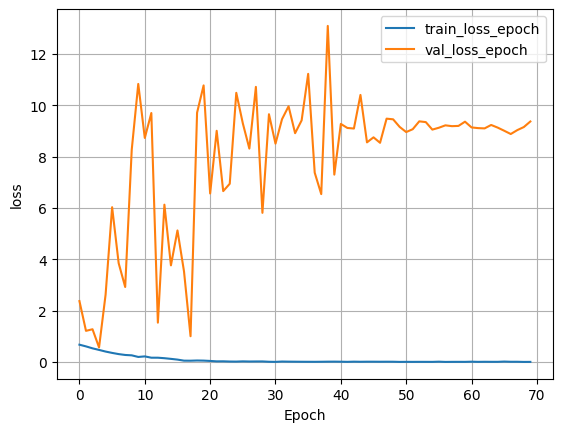

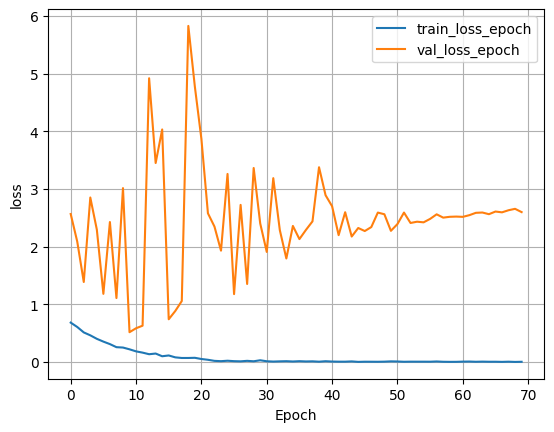

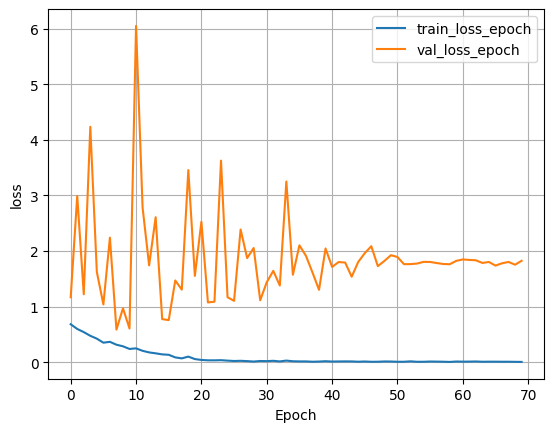

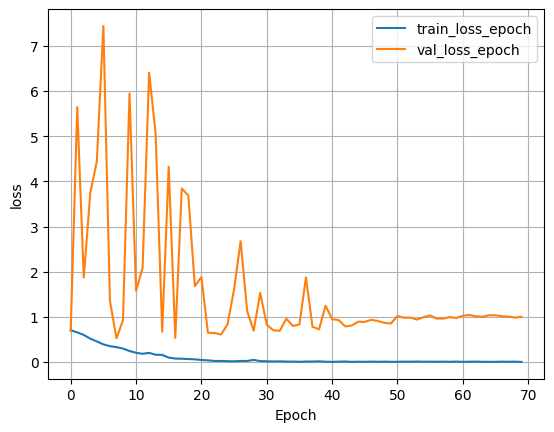

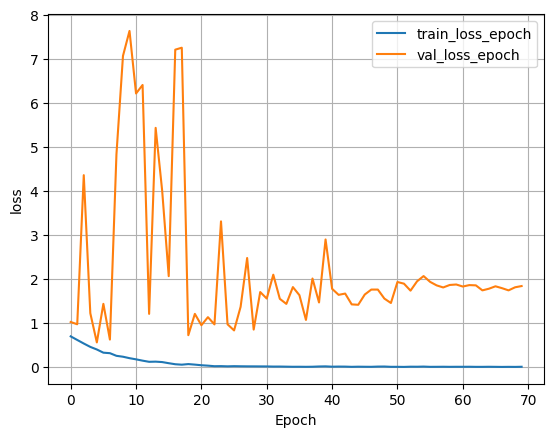

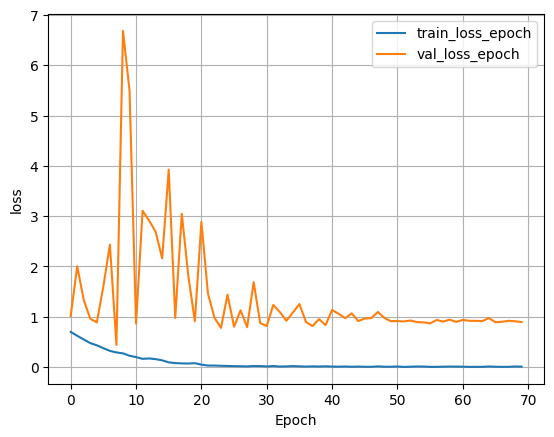

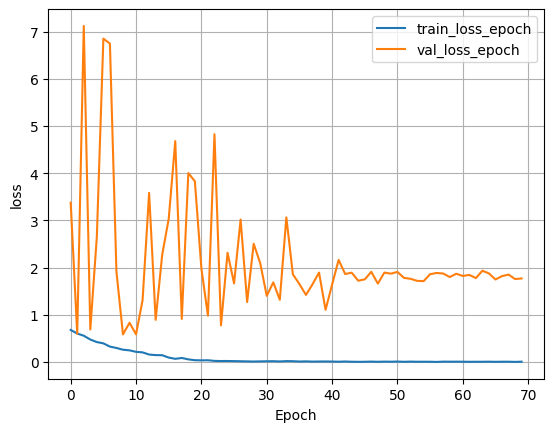

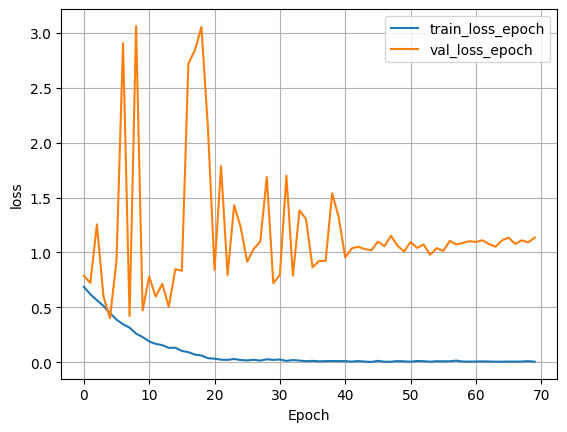

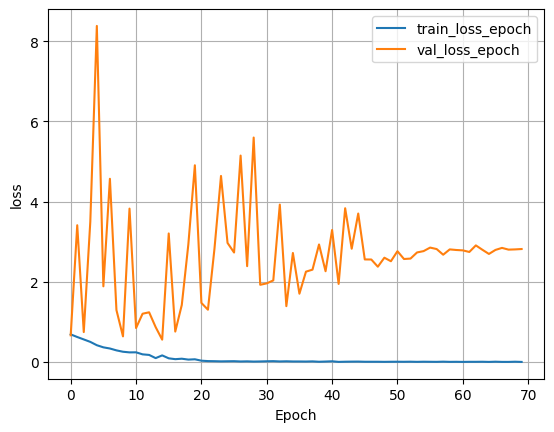

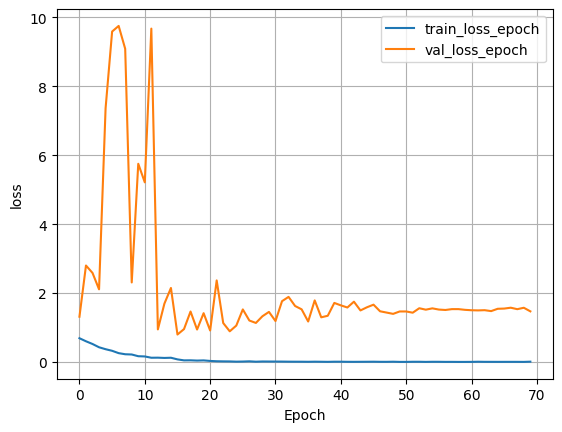

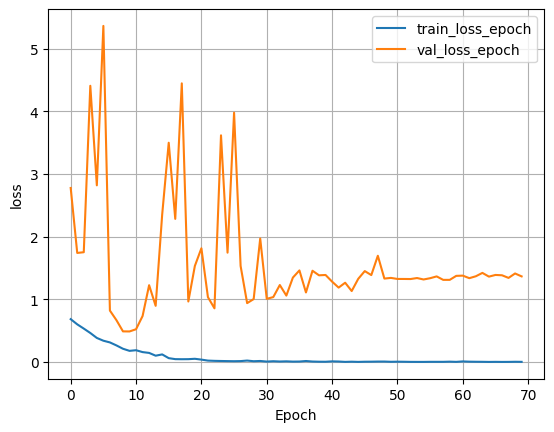

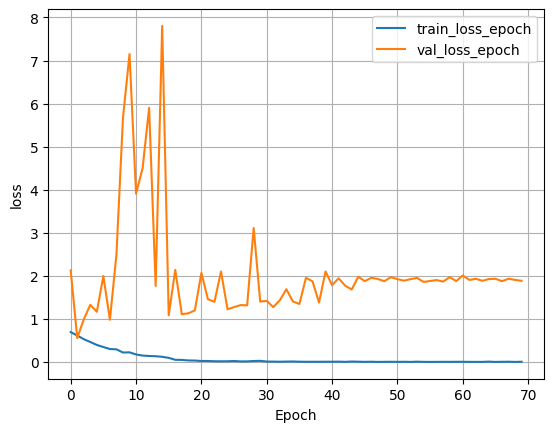

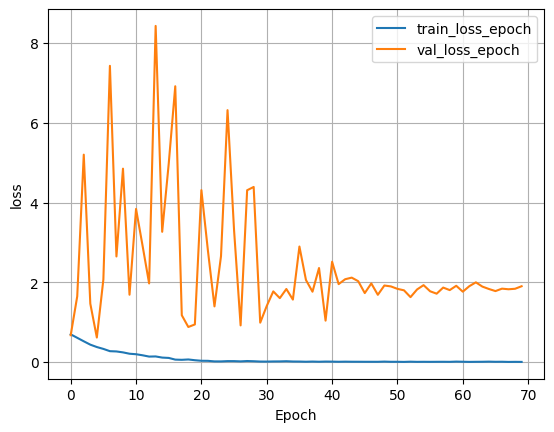

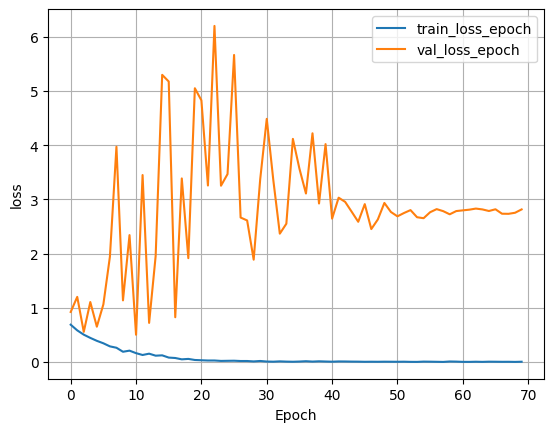

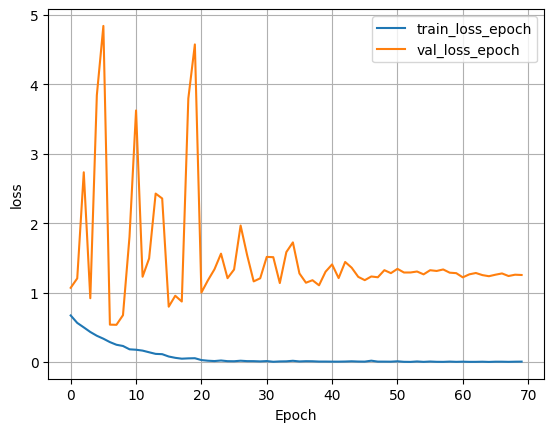

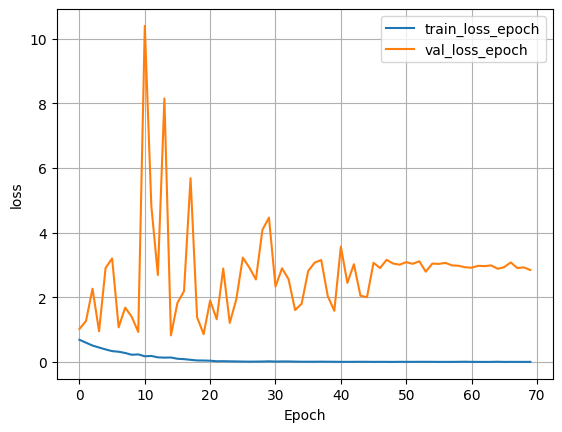

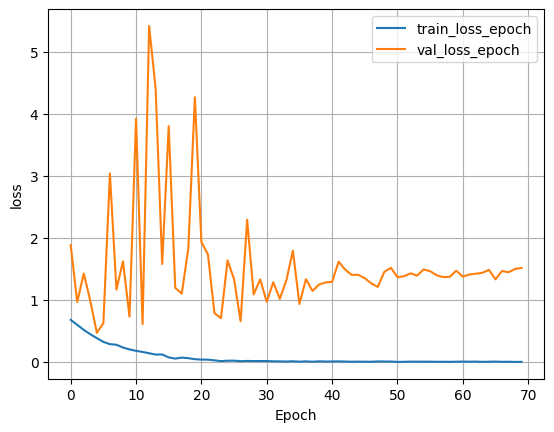

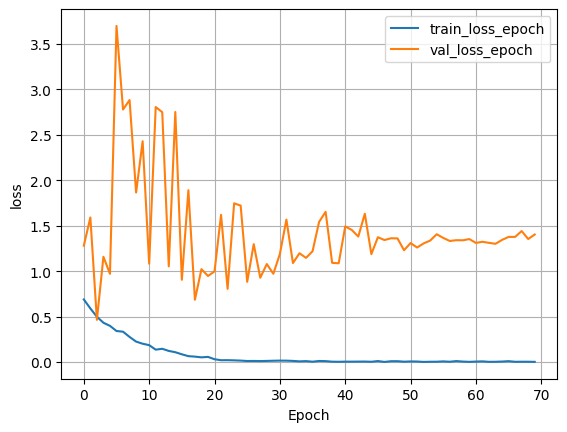

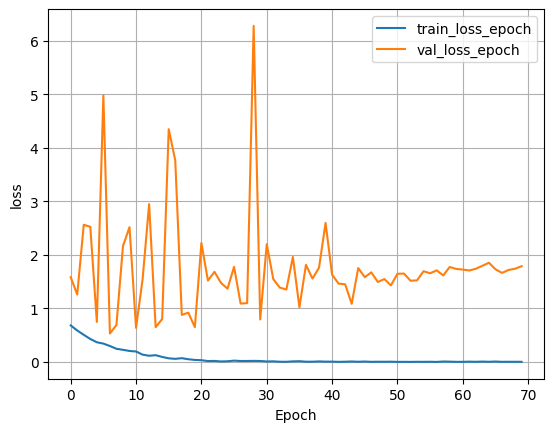

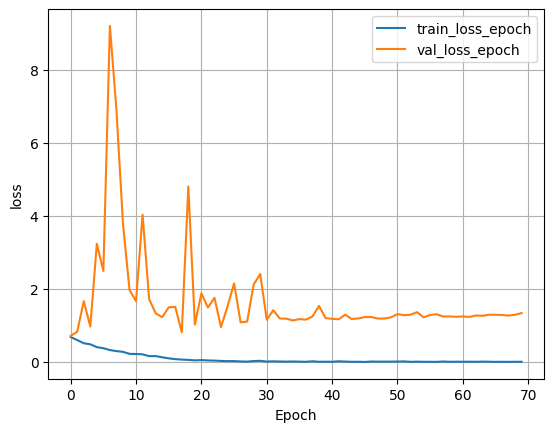

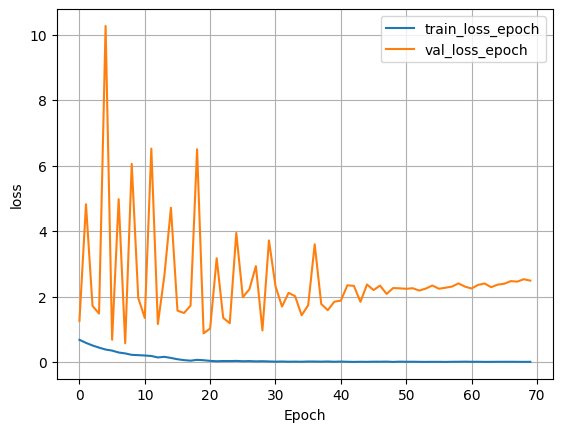

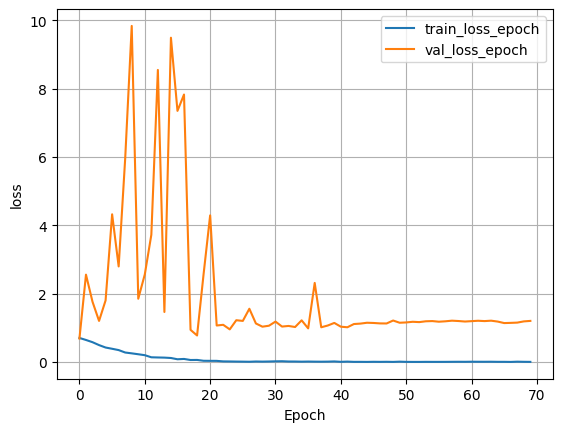

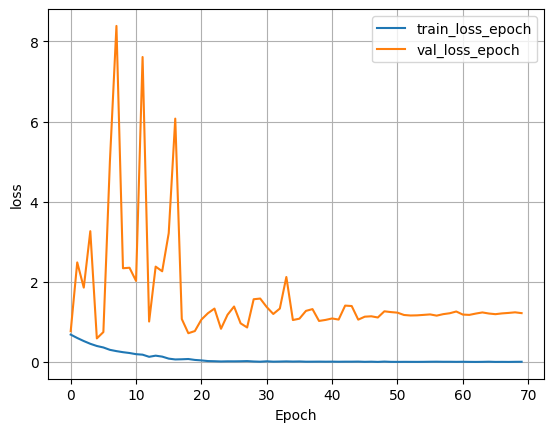

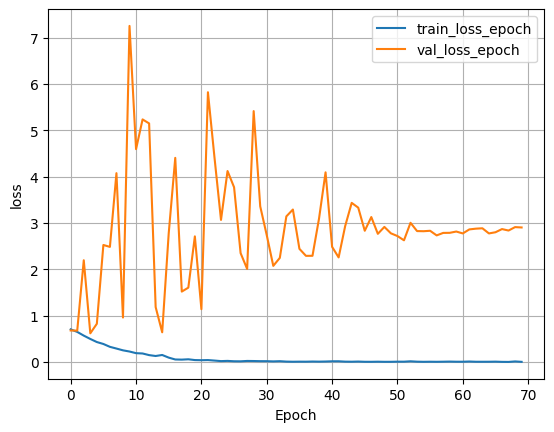

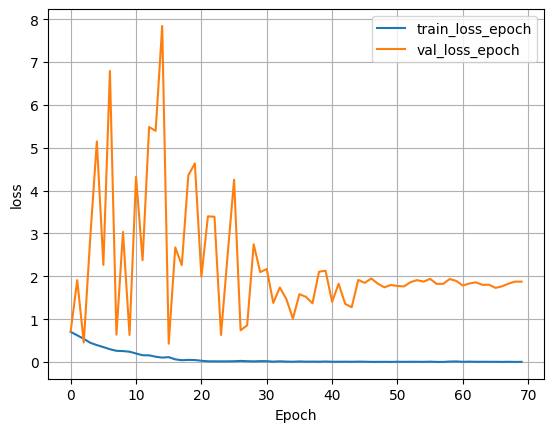

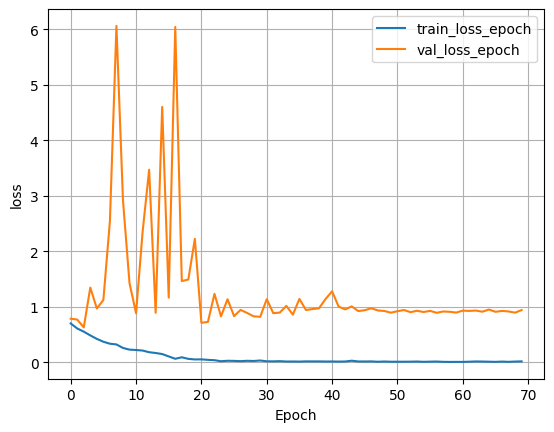

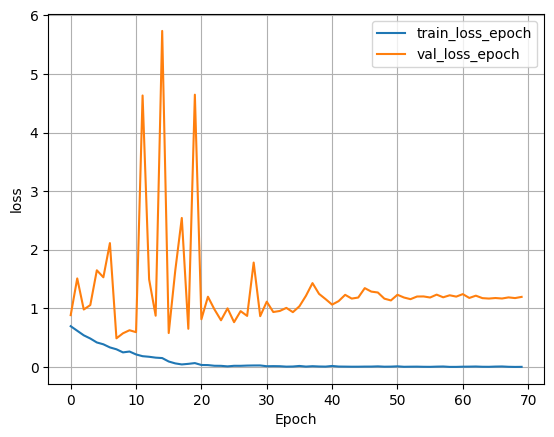

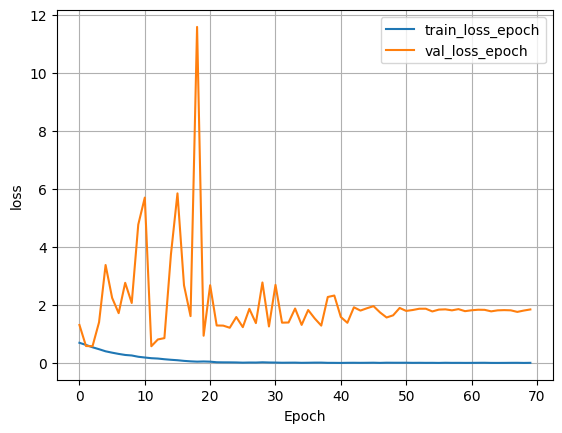

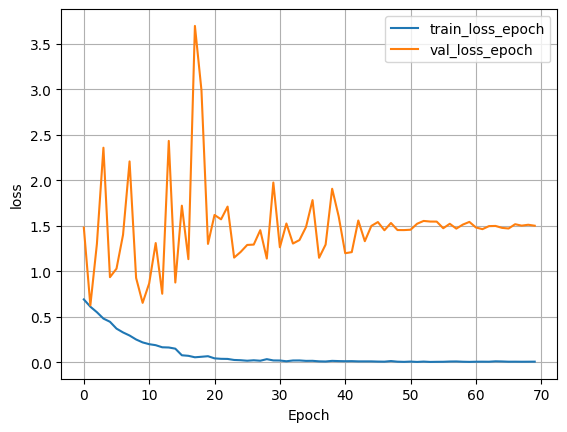

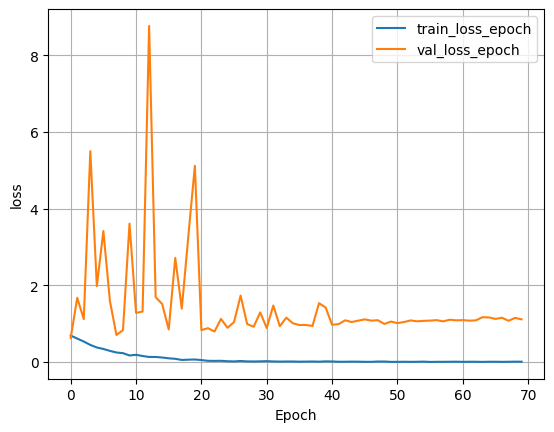

In [24]:
# Train the model over RT-2K dataset for 30 times, 3 times for each of 10 folds
for i in range(10):
    train_dataset.set_active_fold(i)
    test_dataset.set_active_fold(i)
    # max_token_count = max(train_dataset.max_token_count, test_dataset.max_token_count)
    train_dataloader = CharacterandTokenLevelDataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=False)
    test_dataloader = CharacterandTokenLevelDataLoader(test_dataset, batch_size=batch_size, drop_last=False, shuffle=False)
    for j in range(3):
        model_manager = train_model(70, 0.2, 0.000012, 0.0032)
        time.sleep(20)
        torch.cuda.empty_cache()
        import gc
        gc.collect()
        time.sleep(20)

In [25]:
# Function to calculate metrics such as accuracy, f1-score, precision, recall, and confusion matrix
def calculatge_metrics(chpt_path, target_data_loader):
        classifier_torch_model = CNN_for_Text(num_embedding=num_embedding, hidden_dim=hidden_dim, embedding_dim=embedding_dim, pos_emb_size=4096, dropout=0.2, num_out_features=len(class_id), seed=seed, random_edges=4, lattice_edges=8, lattice_step=2, virtual_nodes=0, lattice_start_distance=2)
        classfier_lightning_model = CnnGnnClassifierLightningModel.load_from_checkpoint(chpt_path, model=classifier_torch_model, num_classes=len(class_id)).eval()
        mean_infer_acc = []
        mean_infer_f1 = []
        mean_infer_prec = []
        mean_infer_rec = []
        for i in range(5):
            all_ys = []
            all_y_preds = []
            for X, y in target_data_loader:
                with torch.no_grad():
                    y_pred = classfier_lightning_model(X.to(device))
                all_ys.append(torch.argmax(y,dim=1))
                all_y_preds.append(torch.argmax(y_pred.cpu(), dim=1))
            all_ys = torch.concat(all_ys)
            all_y_preds = torch.concat(all_y_preds)
            
            cm = confusion_matrix(all_ys, all_y_preds)
            
            accuracy = np.sum(np.diag(cm))/ np.sum(cm)
            precision = np.mean(np.diag(cm) / np.sum(cm, axis=0))
            recall = np.mean(np.diag(cm) / np.sum(cm, axis=1))
            f1_score = (2*precision*recall)/(precision + recall)
            
            mean_infer_acc.append(accuracy)
            mean_infer_f1.append(f1_score)
            mean_infer_prec.append(precision)
            mean_infer_rec.append(recall)
        mean_infer_acc = torch.mean(torch.tensor(mean_infer_acc))
        mean_infer_f1 = torch.mean(torch.tensor(mean_infer_f1))
        mean_infer_prec = torch.mean(torch.tensor(mean_infer_prec))
        mean_infer_rec = torch.mean(torch.tensor(mean_infer_rec))
        return mean_infer_acc, mean_infer_f1, mean_infer_prec, mean_infer_rec

In [26]:
# Function to get the epoch of the best model's checkpoint
from os import listdir
from os.path import isfile, join
def get_best_chpt(metrics_path, epoch_numbers):
    epoch_data = pd.read_csv(metrics_path)
    if 'val_acc_epoch' in epoch_data.columns and epoch_data['val_acc_epoch'].notna().any():
        best_chpt = epoch_data.loc[epoch_data['val_acc_epoch'].idxmax()]
    elif 'val_loss_epoch' in epoch_data.columns and epoch_data['val_loss_epoch'].notna().any():
        best_chpt = epoch_data.loc[epoch_data['val_loss_epoch'].idxmin()]
    else:
        raise ValueError(f"No valid validation metrics available for epoch {epoch_numbers}.")
    return np.argwhere(np.array(epoch_numbers)==best_chpt['epoch']).item(), best_chpt['val_loss_epoch']

In [30]:
# Calculate the evaluation metrics for the best model
total_accuracy = []
total_f1 = []
total_prec = []
total_rec = []
total_loss = []
base_path = 'logs\CNN-GNN18_mr2k_seeds'

for i in range(30):
    k_fold_num = i//3
    test_dataset.set_active_fold(k_fold_num)
    test_dataloader = CharacterandTokenLevelDataLoader(test_dataset, batch_size=batch_size, drop_last=False, shuffle=False)
    
    version_path = join(base_path, f'version_{i}')
    checkpoint_path = join(version_path, f'checkpoints')
    onlyfiles  = [f for f in listdir(checkpoint_path) if (isfile(join(checkpoint_path, f)) and 'epoch' in f) ]
    epoch_numbers = [int(re.search(r'\d+', f).group()) for f in onlyfiles]
    best_chpt_id, loss = get_best_chpt(join(version_path, 'metrics.csv'), epoch_numbers)
    print(onlyfiles[best_chpt_id])
    print(f"checkpoint_path: {checkpoint_path}")
    mean_infer_acc, mean_infer_f1, mean_infer_prec, mean_infer_rec = calculatge_metrics(join(checkpoint_path, f'{onlyfiles[best_chpt_id]}'), test_dataloader)

    total_accuracy.append(mean_infer_acc)
    total_f1.append(mean_infer_f1)
    total_prec.append(mean_infer_prec)
    total_rec.append(mean_infer_rec)
    total_loss.append(loss)

total_accuracy = torch.mean(torch.tensor(total_accuracy))
total_f1 = torch.mean(torch.tensor(total_f1))
total_prec = torch.mean(torch.tensor(total_prec))
total_rec = torch.mean(torch.tensor(total_rec))
total_loss = torch.mean(torch.tensor(total_loss))
print(f'total_accuracy: {total_accuracy}')
print(f'total_f1: {total_f1}')
print(f'total_prec: {total_prec}')
print(f'total_rec: {total_rec}')
print(f'total_loss: {total_loss}')

epoch=24-step=900.ckpt
checkpoint_path: logs\CNN-GNN18_mr2k_seeds\version_0\checkpoints


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=17-step=648.ckpt
checkpoint_path: logs\CNN-GNN18_mr2k_seeds\version_1\checkpoints


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=11-step=432.ckpt
checkpoint_path: logs\CNN-GNN18_mr2k_seeds\version_2\checkpoints


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=22-step=828.ckpt
checkpoint_path: logs\CNN-GNN18_mr2k_seeds\version_3\checkpoints


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=23-step=864.ckpt
checkpoint_path: logs\CNN-GNN18_mr2k_seeds\version_4\checkpoints


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=28-step=1044.ckpt
checkpoint_path: logs\CNN-GNN18_mr2k_seeds\version_5\checkpoints


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=29-step=1080.ckpt
checkpoint_path: logs\CNN-GNN18_mr2k_seeds\version_6\checkpoints


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=23-step=864.ckpt
checkpoint_path: logs\CNN-GNN18_mr2k_seeds\version_7\checkpoints


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=30-step=1116.ckpt
checkpoint_path: logs\CNN-GNN18_mr2k_seeds\version_8\checkpoints


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=13-step=504.ckpt
checkpoint_path: logs\CNN-GNN18_mr2k_seeds\version_9\checkpoints


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=35-step=1296.ckpt
checkpoint_path: logs\CNN-GNN18_mr2k_seeds\version_10\checkpoints


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=30-step=1116.ckpt
checkpoint_path: logs\CNN-GNN18_mr2k_seeds\version_11\checkpoints


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=38-step=1404.ckpt
checkpoint_path: logs\CNN-GNN18_mr2k_seeds\version_12\checkpoints


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=39-step=1440.ckpt
checkpoint_path: logs\CNN-GNN18_mr2k_seeds\version_13\checkpoints


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=10-step=396.ckpt
checkpoint_path: logs\CNN-GNN18_mr2k_seeds\version_14\checkpoints


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=63-step=2304.ckpt
checkpoint_path: logs\CNN-GNN18_mr2k_seeds\version_15\checkpoints


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=19-step=720.ckpt
checkpoint_path: logs\CNN-GNN18_mr2k_seeds\version_16\checkpoints


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=23-step=864.ckpt
checkpoint_path: logs\CNN-GNN18_mr2k_seeds\version_17\checkpoints


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=25-step=936.ckpt
checkpoint_path: logs\CNN-GNN18_mr2k_seeds\version_18\checkpoints


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=29-step=1080.ckpt
checkpoint_path: logs\CNN-GNN18_mr2k_seeds\version_19\checkpoints


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=43-step=1584.ckpt
checkpoint_path: logs\CNN-GNN18_mr2k_seeds\version_20\checkpoints


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=23-step=864.ckpt
checkpoint_path: logs\CNN-GNN18_mr2k_seeds\version_21\checkpoints


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=30-step=1116.ckpt
checkpoint_path: logs\CNN-GNN18_mr2k_seeds\version_22\checkpoints


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=27-step=1008.ckpt
checkpoint_path: logs\CNN-GNN18_mr2k_seeds\version_23\checkpoints


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=14-step=540.ckpt
checkpoint_path: logs\CNN-GNN18_mr2k_seeds\version_24\checkpoints


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=15-step=576.ckpt
checkpoint_path: logs\CNN-GNN18_mr2k_seeds\version_25\checkpoints


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=42-step=1548.ckpt
checkpoint_path: logs\CNN-GNN18_mr2k_seeds\version_26\checkpoints


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=25-step=936.ckpt
checkpoint_path: logs\CNN-GNN18_mr2k_seeds\version_27\checkpoints


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=11-step=432.ckpt
checkpoint_path: logs\CNN-GNN18_mr2k_seeds\version_28\checkpoints


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=33-step=1224.ckpt
checkpoint_path: logs\CNN-GNN18_mr2k_seeds\version_29\checkpoints


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


total_accuracy: 0.8824333333333333
total_f1: 0.88366997831071
total_prec: 0.8851163824257822
total_rec: 0.882248854351806
total_loss: 0.903635107477506


### The results:
- total_accuracy: 0.8196
- total_f1: 0.8213116001058066
- total_prec: 0.8230928666170746
- total_rec: 0.8195650287842421
- total_loss: 0.9619055171807607